In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config InlineBackend.figure_formats = ['svg']

In [3]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['FreeSans']
# matplotlib.rc('pdf', fonttype=42)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [5]:
# Ground truth MDP model
MDP_parameters = joblib.load('../data/MDP_parameters.joblib')
P = MDP_parameters['transition_matrix_absorbing'] # (A, S, S_next)
R = MDP_parameters['reward_matrix_absorbing_SA'] # (S, A)
nS, nA = R.shape
gamma = 0.99

# unif rand isd, mixture of diabetic state
PROB_DIAB = 0.2
isd = joblib.load('../data/modified_prior_initial_state_absorbing.joblib')
isd = (isd > 0).astype(float)
isd[:720] = isd[:720] / isd[:720].sum() * (1-PROB_DIAB)
isd[720:] = isd[720:] / isd[720:].sum() * (PROB_DIAB)

# Optimal value function and optimal return
V_star = joblib.load('../data/V_π_star_PE.joblib')
J_star = V_star @ isd

In [6]:
num_runs = 10

In [7]:
to_plot = 'Regret'

## Exp vasize

In [9]:
dfs_va10k = [pd.read_csv('../exp--main/results/run{}/sepsis-cont-HP-va.csv'.format(run), index_col=0) for run in range(num_runs)]
dfs_va500 = [pd.read_csv('./results/run{}/sepsis-cont-HP-va500.csv'.format(run), index_col=0) for run in range(num_runs)]
dfs_va1k = [pd.read_csv('./results/run{}/sepsis-cont-HP-va1k.csv'.format(run), index_col=0) for run in range(num_runs)]
dfs_va5k = [pd.read_csv('./results/run{}/sepsis-cont-HP-va5k.csv'.format(run), index_col=0) for run in range(num_runs)]

In [10]:
regrets_va10k = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_va10k)], axis=1).T.drop(columns=['FQI'])
regrets_va10k['Case'] = '10k'
regrets_va5k = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_va5k)], axis=1).T.drop(columns=['FQI'])
regrets_va5k['Case'] = '5k'
regrets_va1k = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_va1k)], axis=1).T.drop(columns=['FQI'])
regrets_va1k['Case'] = '1k'
regrets_va500 = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_va500)], axis=1).T.drop(columns=['FQI'])
regrets_va500['Case'] = '500'

In [11]:
regrets_exp2 = pd.concat([regrets_va500, regrets_va1k, regrets_va5k, regrets_va10k])
regrets_exp2.columns.name = 'OPE'
regrets_exp2 = pd.DataFrame(regrets_exp2.set_index('Case').stack().rename(to_plot)).reset_index()

In [12]:
regrets_exp2 = regrets_exp2[regrets_exp2['OPE'].isin(['WIS', 'AM', 'FQE'])]

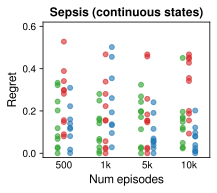

In [13]:
df = regrets_exp2.groupby(['Case', 'OPE']).agg(['min', 'median', 'max']).unstack()
df.columns = df.columns.droplevel()
df = df.loc[['500', '1k', '5k', '10k']]
ncases, nlines = df.loc[:,'median'].shape

fig, ax = plt.subplots(figsize=(3, 2.5))
for i, (name, color, mark) in enumerate(zip(
    ['WIS', 'AM', 'FQE'],
    ['tab:green', 'tab:red', 'tab:blue'],
    ['o', 'd', '^']
)):
    xpos = np.arange(ncases) + 0.15 * (i+0.5-nlines/2)
    
    yval, ylo, yhi = df.loc[:,('median', name)], df.loc[:,('min', name)], df.loc[:,('max', name)]
    yerrs = np.array([yval-ylo, yhi-yval])
    
    yvals = regrets_exp2[regrets_exp2['OPE'] == name][to_plot].values.reshape((ncases, num_runs))
    plt.plot(xpos, yvals, ls='None', c=color, marker='o', markersize=5, markeredgewidth=1, zorder=10, alpha=0.6)

plt.xticks([0,1,2,3], ['500', '1k', '5k', '10k'])
plt.xlim(-0.5, 3.5)
plt.ylim(-0.02, 0.62)

ax.tick_params(axis='x', length=0)
plt.xlabel('Num episodes', fontsize=12)
plt.ylabel(to_plot, fontsize=12)
plt.title('Sepsis (continuous states)', fontsize=12, fontweight='bold')
plt.savefig('fig/sepsis-cont-exp-HP-size.pdf', bbox_inches='tight')
plt.show()